# Transfer function

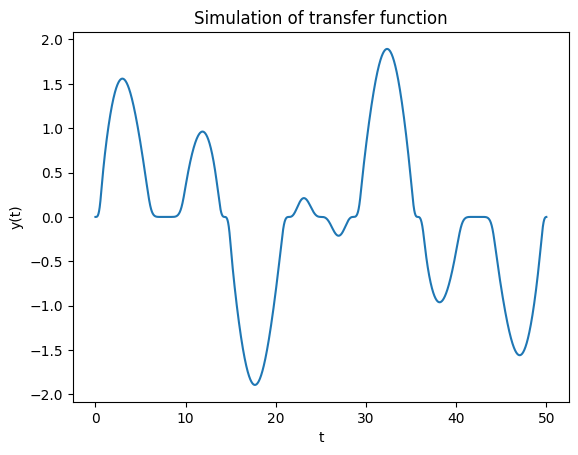

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

dt = 0.01
T = 50
N = int(T / dt)
t = np.linspace(0, T, N)
u = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)

y_k = np.zeros(N)

for k in range(1, N-1):
    y_k[k+1] = y_kp1(y_k[k], y_k[k-1], u[k-1])

plt.plot(t, y_k)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Simulation of transfer function')
plt.show()

# RBF model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class RadialBasisFunction(nn.Module):
    def __init__(self, input_dim, output_dim, num_neurons):
        super().__init__()

        self.centers = nn.Parameter(torch.rand(input_dim, num_neurons).to(torch.float32))
        self.sigma = nn.Parameter(torch.rand(input_dim, num_neurons).to(torch.float32))

        self.linear = nn.Linear(num_neurons, output_dim)

    def forward(self, x):
        # Compute the RBF kernel
        dists = -torch.pow(x.unsqueeze(-1) - self.centers.unsqueeze(0), 2) / (2 * torch.pow(self.sigma.unsqueeze(0), 2))
        phi = torch.exp(dists.sum(1, keepdim=False))

        # Apply the linear layer
        return self.linear(phi)

In [11]:
# Convert data to PyTorch tensors
y_k_shifted = np.zeros_like(y_k)
y_k_shifted[1:] = y_k[:-1]

X = torch.tensor(np.vstack([y_k_shifted, u]).T).to(torch.float32).view(-1,2)
Y = torch.tensor(y_k).to(torch.float32).view(-1,1)

print(X.shape, Y.shape)
# Define the RBF model
model = RadialBasisFunction(2, 1, 10)

# Train the RBF model
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# All of the data
for epoch in range(100):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, Y)
    loss.backward()
    optimizer.step()

# Data one by one
# for epoch in range(10):
#     for x,y in zip(X, Y):
#         optimizer.zero_grad()
#         output = model(x.view(-1,3))
#         loss = criterion(output, y.view(-1,1))
#         loss.backward()
#         optimizer.step()

# Evaluate the RBF model
with torch.no_grad():
    output = model(X)
    mse = criterion(output, Y).item()

print("MSE:", mse)

torch.Size([5000, 2]) torch.Size([5000, 1])
MSE: 0.0001190330003737472


### Dataloader

In [12]:
import torch
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


# Convert data to PyTorch tensors
y_k_shifted = np.zeros_like(y_k)
y_k_shifted[1:] = y_k[:-1]

y_k_shifted = np.zeros_like(y_k)
y_k_shifted[1:] = y_k[:-1]

X = torch.tensor(np.vstack([y_k_shifted, u]).T).to(torch.float32).view(-1,2)
Y = torch.tensor(y_k).to(torch.float32).view(-1,1)

print(X.shape, Y.shape)
# Define the RBF model
model = RadialBasisFunction(2, 1, 10)

# Train the RBF model
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataloader = DataLoader(MyDataset(X,Y), batch_size=32, shuffle=False)

# All of the data
for epoch in range(100):
    for i, (x,y) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

# Evaluate the RBF model
with torch.no_grad():
    output = model(X)
    mse = criterion(output, Y).item()

print("MSE:", mse)


torch.Size([5000, 2]) torch.Size([5000, 1])
MSE: 0.0010929779382422566


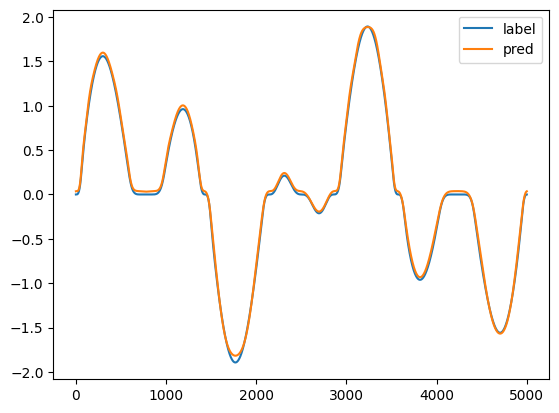

In [14]:
plt.plot(Y.numpy().ravel())
plt.plot(output.numpy().ravel())
plt.legend(['label','pred'])

# RBF Control

### Referece model

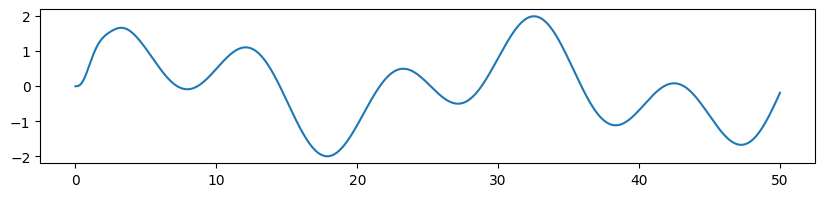

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

w_n = 3.1623
zita = 0.316
K = 1

num = [K]
den = [1/w_n**2, 2*zita/w_n, 1]

transfer_function = ctrl.TransferFunction(num, den)

dt = 0.01
T = 50
N = int(T / dt)
t = np.linspace(0, T, N)
u = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)

resp = ctrl.forced_response(transfer_function, t, u)
t, output, state = resp.time, resp.outputs, resp.states

u = u.reshape([-1,1])
y_m = output.reshape([-1,1])

plt.figure(figsize=(10,2))
plt.plot(t, y_m)

In [ ]:
from utils.buffer import ReplayBuffer

batch_size = 1
memory = ReplayBuffer(batch_size)

# RBF models
learning_rate = 0.001

observer = RadialBasisFunction(2, 1, 10)
observer_criterion = nn.MSELoss()
observer_optim = torch.optim.Adam(observer.parameters(), lr=learning_rate)

controller = RadialBasisFunction(3, 1, 10)
controller_criterion = nn.MSELoss()
controller_optim = torch.optim.Adam(controller.parameters(), lr=learning_rate)

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

def prepare_inputs(u, y_p):
    # Convert data to PyTorch tensors
    y_p_shifted = np.zeros_like(y_p)
    y_p_shifted[1:] = y_p[:-1]

    u_shifted = np.zeros_like(u)
    u_shifted[1:] = u[:-1]

    r = np.zeros_like(y_p)
    r = y_ref

    # observer input
    obs_input = torch.tensor(np.vstack([y_k_shifted, u]).T).to(torch.float32).view(-1,2)
    obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)
    
    # controller input
    cntrl_input = torch.tensor(np.vstack([r, y_k_shifted, u_shifted]).T).to(torch.float32).view(-1,3)
    cntrl_label = torch.tensor(u).to(torch.float32).view(-1,1)

    return obs_input, obs_label, cntrl_input, cntrl_label

for y_ref in y_m:
    else:
        u_hat = np.random.rand()
        y_next_k = y_kp1(y_p[-1], y_p[-2], u_hat[-1])
        memory.push([u_hat[-1], y_next_k])
    
        u, y_p = memory.sample(len(memory))

        # step plant
        with torch.no_grad():
            u_hat = controller(cntrl_input)
            y_next_k = y_kp1(y_p[-1], y_p[-2], u_hat[-1])

        memory.push([u_hat[-1], y_next_k])

    if len(memory) >= batch_size:
        u, y_p = memory.sample(len(memory))
        obs_input, obs_label, cntrl_input, cntrl_label = prepare_inputs(u, y_p)

        # update observer
        observer_optim.zero_grad()
        y_p_hat = observer(obs_input)
        observer_loss = observer_criterion(y_p_hat, obs_label)
        observer_loss.backward()
        observer_optim.step()

        # update controller
        observer_optim.zero_grad()
        u_hat = controller(cntrl_input)
        y_p_hat = observer(u_hat)
        controller_loss = controller_criterion(y_p_hat, cntrl_label)
        controller_loss.backward()
        controller_optim.step()

